In [1]:
# Importing the libraries
import numpy as np # for array operations
import pandas as pd # for working with DataFrames
import geopandas as gpd
import requests, io # for HTTP requests and I/O commands
import matplotlib.pyplot as plt # for data visualization
%matplotlib inline

# scikit-learn modules
from sklearn.model_selection import train_test_split # for splitting the data
from sklearn.metrics import mean_squared_error # for calculating the cost function
from sklearn.ensemble import RandomForestRegressor # for building the model

In [2]:
# Importing the data
dataset = gpd.read_file(r'C:\Users\mieke\Documents\Msc Thesis\Datasets\Yield Data\Karnataka\rf_geodataframe1.geojson') 
dataset.head()

,Year,Season,Insurance Unit,Gram Panchayat/Hobli,District,Taluk,Crop,IRR_RF,Average Yield(Kg/Ha),Previous Average Yield(Kg/Ha),...,SSM_sow,SSM_between,SSM_harvest,LST_sow,LST_between,LST_harvest,max_LST_sow,max_LST_between,max_LST_harvest,geometry
0,2017,Kharif,114. danapura,gp,ballari,hosapete,paddy,irr,5545.670,NaN,...,3.586822,6.009483,14.166774,42.298838,NaN,30.052126,45.416668,NaN,32.234375,"POLYGON ((76.71971 15.44185, 76.71971 15.44178..."
1,2018,Kharif,114. danapura,gp,ballari,hosapete,paddy,irr,6568.498,5545.67,...,4.271417,11.246229,12.388197,34.745437,26.941840,28.703179,37.708332,28.56250,30.614286,"POLYGON ((76.71971 15.44185, 76.71971 15.44178..."
2,2016,Kharif,34 nekkilady,gp,dakshina_kannada,puttur,paddy,rf,4571.730,NaN,...,24.618298,25.066746,22.127859,29.937500,NaN,30.073175,30.062500,NaN,30.184896,"POLYGON ((75.22906 12.83831, 75.22912 12.83833..."
3,2016,Kharif,38 kalathur,gp,udupi,udupi,paddy,rf,3855.780,NaN,...,23.172031,24.921982,21.779053,30.214286,25.130208,30.162149,30.562500,27.90625,31.114584,"POLYGON ((74.95270 13.45764, 74.95274 13.45742..."
4,2017,Kharif,38 kalathur,gp,udupi,udupi,paddy,rf,3912.760,3855.78,...,24.008156,24.914917,23.961044,26.990809,NaN,30.206761,27.750000,NaN,31.427084,"POLYGON ((74.95270 13.45764, 74.95274 13.45742..."


In [11]:
#dataset['Previous Average Yield(Kg/Ha)'] = dataset['Previous Average Yield(Kg/Ha)'].fillna(dataset['Average Yield(Kg/Ha)'])
dataset_copy = dataset.copy()
dataset_copy.loc[(dataset_copy['Season'] == 'Summer'), 'Season'] = 0
dataset_copy.loc[(dataset_copy['Season'] == 'Kharif'), 'Season'] = 1
dataset_copy.loc[(dataset_copy['Season'] == 'Rabi'), 'Season'] = 2


dataset_copy.loc[(dataset_copy['IRR_RF'] == 'irr'), 'IRR_RF'] = 0
dataset_copy.loc[(dataset_copy['IRR_RF'] == 'rf'), 'IRR_RF'] = 1

In [12]:
unique_crop = sorted(dataset_copy['Crop'].unique()) # All possible crop types
dataset_copy.groupby('Crop').size().sort_values(ascending=False) # Sort values based on group size

Crop
paddy                                                8939
maize (makka)                                        7817
sorghum (jowar/great millet)                         5657
ragi                                                 4114
bengal gram                                          3869
pigeon pea (red gram/arhar/tur)                      3592
groundnut                                            2948
horse gram (kulthi/kultha)                           1733
green gram (moong bean/ moong)                       1411
wheat                                                1321
pearl millet (bajra/bulrush millet/spiked millet)    1245
sunflower                                            1193
soybean (bhat)                                        999
cotton                                                663
onion                                                 654
tomato                                                493
sesame (gingelly/til)/sesamum                         421
black gra

In [13]:
dataset_subset.columns

Index(['Year', 'Season', 'Insurance Unit', 'Gram Panchayat/Hobli', 'District',
       'Taluk', 'Crop', 'IRR_RF', 'Average Yield(Kg/Ha)', 'LAI_sow',
       'LAI_harvest', 'NDVI_sow', 'NDVI_harvest', 'SSM_sow', 'SSM_harvest',
       'LST_sow', 'LST_harvest', 'max_LST_sow', 'max_LST_harvest', 'geometry',
       'Area'],
      dtype='object')

In [32]:
# Select a subset of the dataframe related to the crop of interest
dataset_subset = dataset_copy[dataset_copy['Crop'] == 'paddy'] # For now, we select paddy as this has most occurences
print(len(dataset_subset))
#dataset_subset = dataset_subset[dataset_subset['Average Yield(Kg/Ha)'] != 0] # drop data with an average yield of 0 (as this does not sound plausible)
dataset_subset = dataset_subset.drop(['Previous Average Yield(Kg/Ha)', 'LAI_between', 'NDVI_between', 'SSM_between', 'LST_between', 'max_LST_between'], axis = 1)
dataset_subset = dataset_subset.dropna(axis=0) # drop data with missing values in certain columns (RandomForestRegressor can not handle them)
print(len(dataset_subset))
# Use dataset.columns to check which columns to drop in order to select the correct features
sqm_to_sqkm = 10**6
dataset_subset['Area'] = dataset_subset.to_crs(epsg = 3857).geometry.area / sqm_to_sqkm
x = dataset_subset.drop(['Insurance Unit', 'Gram Panchayat/Hobli', 'District', 'Taluk', 'Crop', 'geometry', 'Average Yield(Kg/Ha)'], axis = 1) # Features
## OR
#x = dataset_subset.drop(['Year', 'Insurance Unit', 'Gram Panchayat/Hobli', 'District', 'Taluk', 'Crop', 'geometry', 'Average Yield(Kg/Ha)'], axis = 1) # Features
y = dataset_subset['Average Yield(Kg/Ha)']  # Target

8939
8100


In [38]:
## FEATURE IMPORTANCE SELECTION
# Select a subset of the dataframe related to the crop of interest
dataset_subset = dataset_copy[dataset_copy['Crop'] == 'paddy'] # For now, we select paddy as this has most occurences
print(len(dataset_subset))
#dataset_subset = dataset_subset[dataset_subset['Average Yield(Kg/Ha)'] != 0] # drop data with an average yield of 0 (as this does not sound plausible)
dataset_subset = dataset_subset.drop(['Previous Average Yield(Kg/Ha)', 'LAI_between', 'NDVI_between', 'SSM_between', 'LST_between', 'max_LST_between'], axis = 1)
dataset_subset = dataset_subset.dropna(axis=0) # drop data with missing values in certain columns (RandomForestRegressor can not handle them)
print(len(dataset_subset))
# Use dataset.columns to check which columns to drop in order to select the correct features
sqm_to_sqkm = 10**6
dataset_subset['Area'] = dataset_subset.to_crs(epsg = 3857).geometry.area / sqm_to_sqkm
x = dataset_subset.drop(['Insurance Unit', 'Gram Panchayat/Hobli', 'District', 'Taluk', 'Crop', 'geometry', 'Average Yield(Kg/Ha)', 'Season'], axis = 1) # Features
## OR
#x = dataset_subset.drop(['Year', 'Insurance Unit', 'Gram Panchayat/Hobli', 'District', 'Taluk', 'Crop', 'geometry', 'Average Yield(Kg/Ha)'], axis = 1) # Features
y = dataset_subset['Average Yield(Kg/Ha)']  # Target

8939
8100


In [39]:
# Splitting the dataset into training and testing set (80/20)
# NOTE: random_state is set to an integer such that we use the same random seed each time we run this code
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [40]:
# Initializing the Random Forest Regression model with n_estimators decision trees
model = RandomForestRegressor(n_estimators = 1000, random_state = 1)

# Fitting the Random Forest Regression model to the data
model.fit(x_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=1)

In [41]:
from matplotlib import pyplot
importance = model.feature_importances_ # feature importance
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))


Feature: 0, Score: 0.01236
Feature: 1, Score: 0.03816
Feature: 2, Score: 0.15926
Feature: 3, Score: 0.08092
Feature: 4, Score: 0.07027
Feature: 5, Score: 0.07200
Feature: 6, Score: 0.12817
Feature: 7, Score: 0.08405
Feature: 8, Score: 0.06220
Feature: 9, Score: 0.06532
Feature: 10, Score: 0.06590
Feature: 11, Score: 0.07590
Feature: 12, Score: 0.08547


In [42]:
x.columns
#LAI_sow, SSM_sow, Area, SSM_harvest, max_LST_harvest
#LAI_sow, SSM_sow, Area, SSM_harvest, max_LST_harvest 

Index(['Year', 'IRR_RF', 'LAI_sow', 'LAI_harvest', 'NDVI_sow', 'NDVI_harvest',
       'SSM_sow', 'SSM_harvest', 'LST_sow', 'LST_harvest', 'max_LST_sow',
       'max_LST_harvest', 'Area'],
      dtype='object')

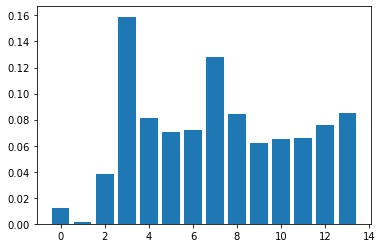

In [21]:
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [24]:
len(x.columns) # LAI_sow, # SSM_sow, # SSM_harvest, # Area
importance

array([0.01224872, 0.0014941 , 0.03816087, 0.15901606, 0.0809521 ,
       0.07031797, 0.07198473, 0.12778483, 0.08399021, 0.06192581,
       0.06518862, 0.0658829 , 0.07579776, 0.0852553 ])

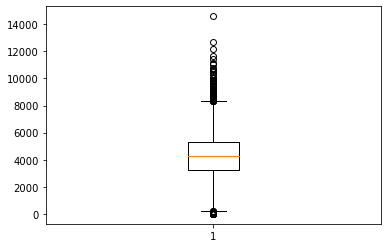

In [53]:
# Creating plot
plt.boxplot(dataset_subset['Average Yield(Kg/Ha)'])
 
# show plot
plt.show()

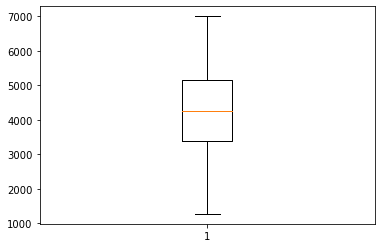

In [62]:
fifth_perc = np.percentile(dataset_subset['Average Yield(Kg/Ha)'], 5)
nintyfifth_perc = np.percentile(dataset_subset['Average Yield(Kg/Ha)'], 95)
outliers = [i for i in dataset_subset['Average Yield(Kg/Ha)'] if i > nintyfifth_perc or i < fifth_perc]
no_outliers = [i for i in dataset_subset['Average Yield(Kg/Ha)'] if i not in outliers]
# Creating plot
plt.boxplot(no_outliers)
 
# show plot
plt.show()

In [56]:
fifth_perc = np.percentile(dataset_subset['Average Yield(Kg/Ha)'], 5)
nintyfifth_perc = np.percentile(dataset_subset['Average Yield(Kg/Ha)'], 95)
#outliers = np.where(np.array(dataset_subset['Average Yield(Kg/Ha)']) > nintyfifth_perc or np.array(dataset_subset['Average Yield(Kg/Ha)']) < fifth_perc)
#no_outliers = [i for i in dataset_subset['Average Yield(Kg/Ha)'] if i not in outliers]
# Creating plot
#plt.boxplot(no_outliers)
 
# show plot
#plt.show()
import itertools
outliers_tf = (dataset_subset['Average Yield(Kg/Ha)'] < nintyfifth_perc) & (dataset_subset['Average Yield(Kg/Ha)'] > fifth_perc)
outliers = list(itertools.compress(dataset_subset['Average Yield(Kg/Ha)'], outliers_tf))

In [59]:
dataset_subset['Average Yield(Kg/Ha)'].head(20)

0       5545.670
1       6568.498
2       4571.730
3       3855.780
4       3912.760
5       4070.883
6       4895.740
7       5223.190
8       4756.020
9       4540.920
10      5058.368
37      1946.760
38      4518.690
39      4518.690
49      4653.850
50      5011.640
51      5372.665
52     12708.360
53      7065.950
105     4239.360
Name: Average Yield(Kg/Ha), dtype: float64

In [35]:
# Predicting the target values of the test set
y_pred = model.predict(x_test)

# RMSE (Root Mean Square Error)
rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("\nRMSE: ", rmse)
# 1333.534
# 1334.37


RMSE:  1333.534


In [61]:
EF = 1 - sum(np.square(y_test - y_pred)) / sum(np.square(y_test - np.mean(y_test)))
EF

0.31247795298884673

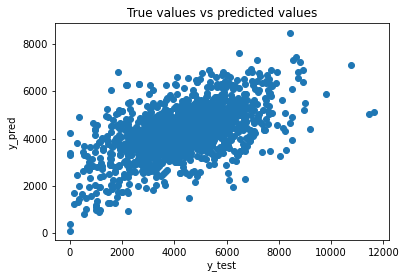

In [60]:
plt.scatter(y_test, y_pred)
plt.title('True values vs predicted values')
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()

New Model

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
# Initializing the Random Forest Regression model with n_estimators decision trees
model = HistGradientBoostingRegressor(max_iter = 1000, max_leaf_nodes=None)#n_estimators = 1000, random_state = 1)

# Fitting the Random Forest Regression model to the data
model.fit(x_train, y_train)

In [ ]:
# Predicting the target values of the test set
y_pred = model.predict(x_test)

# RMSE (Root Mean Square Error)
rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("\nRMSE: ", rmse)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(np.array(dataset['Season']).reshape(-1, 1))

In [ ]:
enc.categories_
drop_enc = OneHotEncoder(drop='first').fit(np.array(dataset['Season']).reshape(-1, 1))
drop_enc.categories_

In [53]:
dataset_subset.iloc[0,:]

Year                                                                          2018
Season                                                                           1
Insurance Unit                                                       114. danapura
Gram Panchayat/Hobli                                                            gp
District                                                                   ballari
Taluk                                                                     hosapete
Crop                                                                         paddy
IRR_RF                                                                           0
Average Yield(Kg/Ha)                                                      6568.498
Previous Average Yield(Kg/Ha)                                              5545.67
LAI_sow                                                                    0.62028
LAI_between                                                               2.683362
LAI_